### 초기 경로 설정 (클래스 이용을 위함)

In [14]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/ehdgus575/segmentation_project


In [15]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [17]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [18]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [19]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [20]:
train_images = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/images/*')
train_labels = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 366 elements
My custom valing-dataset has 123 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

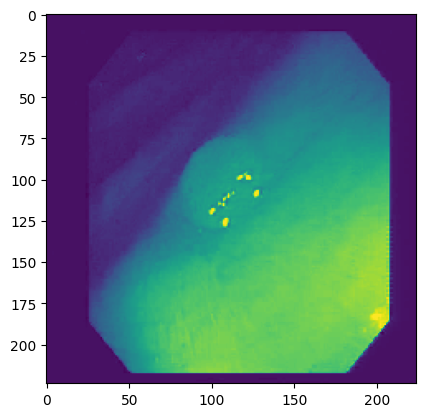

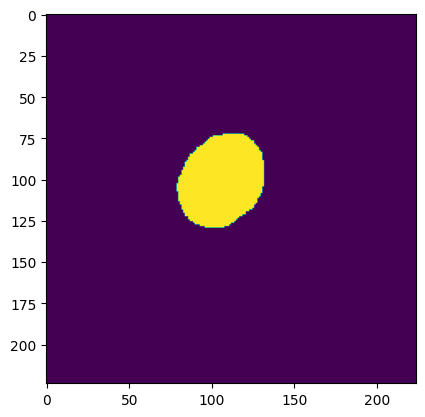

3픽셀의 평균값이라 색깔이 변경됨.


In [21]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [22]:
from models.FCBformer.FCBmodels import FCBFormer

model = FCBFormer(size=224)
model = model.to(DEVICE)

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [23]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [24]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'FCBFormer'
data_name = 'CVC'

# 5. Training

/home/ehdgus575/.conda/envs/cuda_setting/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 46 of 46, Train Loss: 0.631963, IoU: 0.485435, Dice: 0.608094
 Epoch: 1 of 100, Iter.: 46 of 46, Valid Loss: 0.369090, IoU: 0.621516, Dice: 0.729890

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


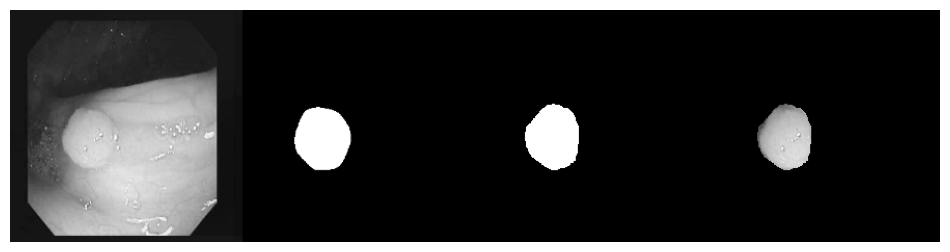

 Epoch: 2 of 100, Iter.: 46 of 46, Train Loss: 0.266126, IoU: 0.706246, Dice: 0.804135
 Epoch: 2 of 100, Iter.: 46 of 46, Valid Loss: 0.277260, IoU: 0.709965, Dice: 0.804663


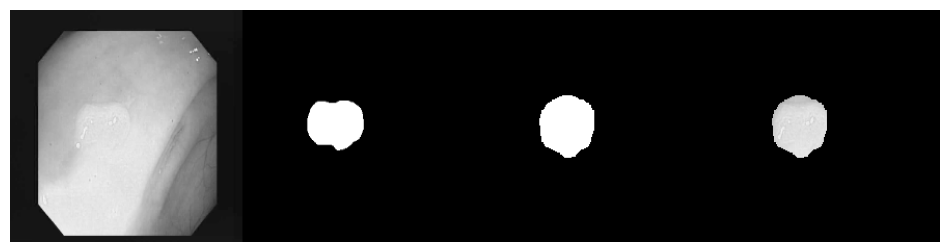

 Epoch: 3 of 100, Iter.: 46 of 46, Train Loss: 0.151627, IoU: 0.805419, Dice: 0.877747
 Epoch: 3 of 100, Iter.: 46 of 46, Valid Loss: 0.229531, IoU: 0.739463, Dice: 0.820047


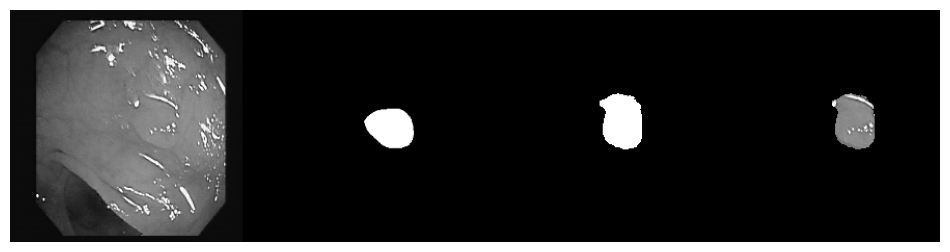

 Epoch: 4 of 100, Iter.: 46 of 46, Train Loss: 0.111607, IoU: 0.853550, Dice: 0.911287
 Epoch: 4 of 100, Iter.: 46 of 46, Valid Loss: 0.206026, IoU: 0.767646, Dice: 0.844755


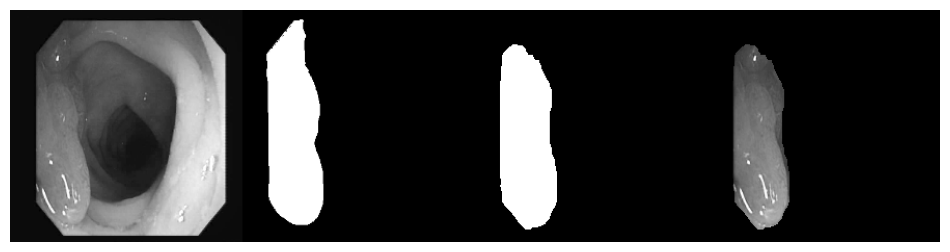

 Epoch: 5 of 100, Iter.: 46 of 46, Train Loss: 0.086550, IoU: 0.876052, Dice: 0.928015
 Epoch: 5 of 100, Iter.: 46 of 46, Valid Loss: 0.180825, IoU: 0.781426, Dice: 0.856792


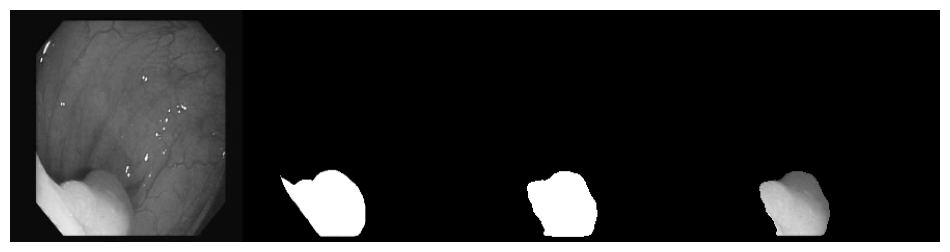

 Epoch: 6 of 100, Iter.: 46 of 46, Train Loss: 0.067625, IoU: 0.898537, Dice: 0.943028
 Epoch: 6 of 100, Iter.: 46 of 46, Valid Loss: 0.184859, IoU: 0.768554, Dice: 0.846848


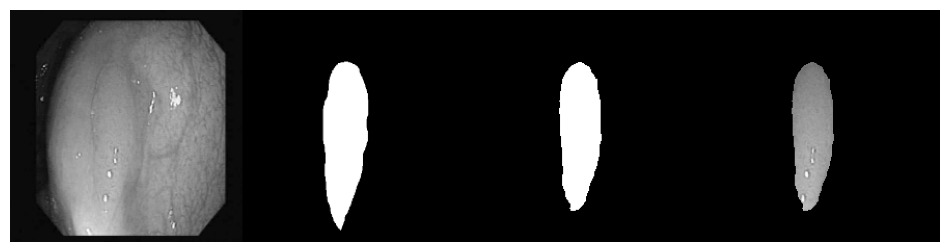

 Epoch: 7 of 100, Iter.: 46 of 46, Train Loss: 0.064720, IoU: 0.901119, Dice: 0.944286
 Epoch: 7 of 100, Iter.: 46 of 46, Valid Loss: 0.175700, IoU: 0.795193, Dice: 0.865287


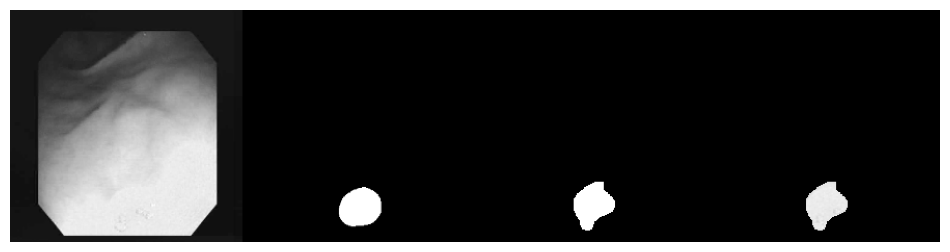

 Epoch: 8 of 100, Iter.: 46 of 46, Train Loss: 0.052653, IoU: 0.915998, Dice: 0.952538
 Epoch: 8 of 100, Iter.: 46 of 46, Valid Loss: 0.190970, IoU: 0.791551, Dice: 0.863022


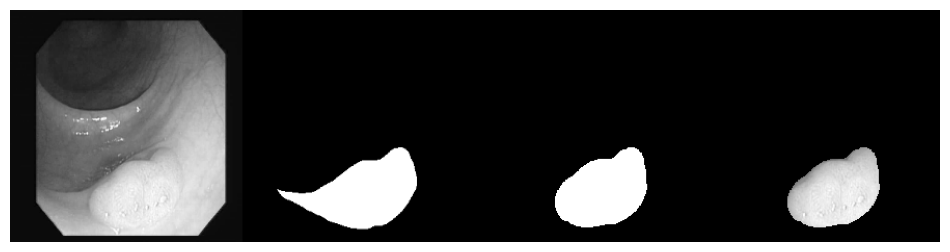

 Epoch: 9 of 100, Iter.: 46 of 46, Train Loss: 0.047301, IoU: 0.925738, Dice: 0.959845
 Epoch: 9 of 100, Iter.: 46 of 46, Valid Loss: 0.211006, IoU: 0.791216, Dice: 0.863617


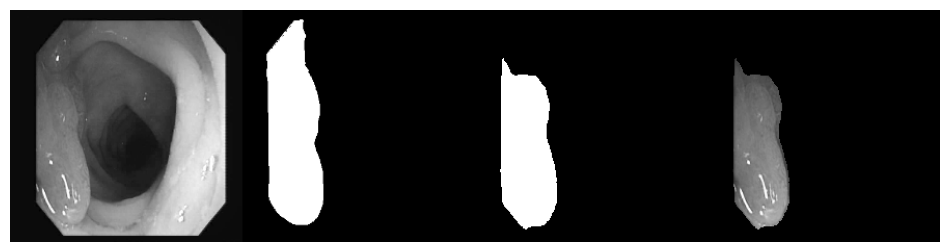

 Epoch: 10 of 100, Iter.: 46 of 46, Train Loss: 0.041920, IoU: 0.932142, Dice: 0.963955
 Epoch: 10 of 100, Iter.: 46 of 46, Valid Loss: 0.198984, IoU: 0.779977, Dice: 0.849843


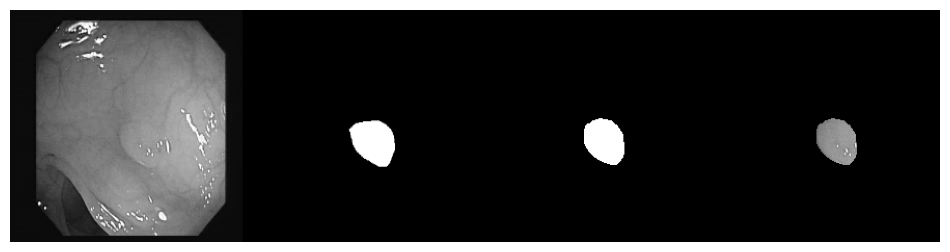

 Epoch: 11 of 100, Iter.: 46 of 46, Train Loss: 0.041434, IoU: 0.933597, Dice: 0.964915
 Epoch: 11 of 100, Iter.: 46 of 46, Valid Loss: 0.194250, IoU: 0.801607, Dice: 0.870520


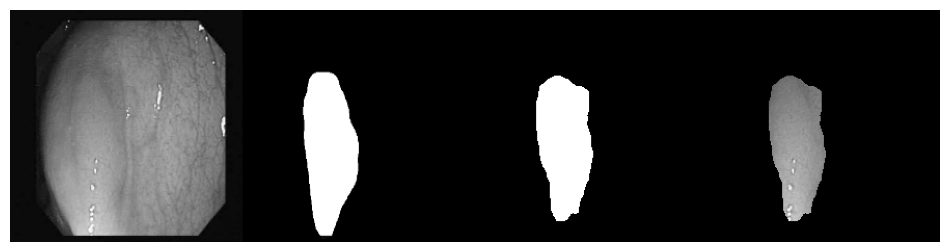

 Epoch: 12 of 100, Iter.: 46 of 46, Train Loss: 0.040894, IoU: 0.940079, Dice: 0.968493
 Epoch: 12 of 100, Iter.: 46 of 46, Valid Loss: 0.204701, IoU: 0.794972, Dice: 0.866544


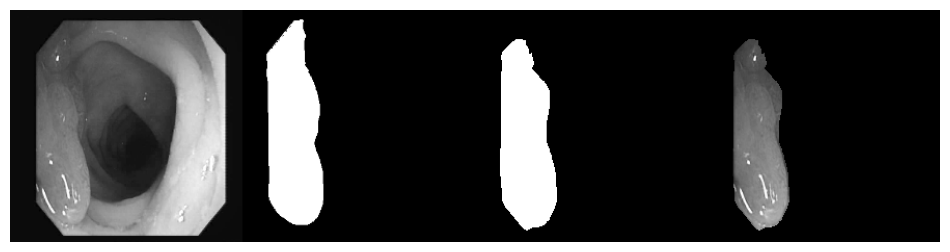

 Epoch: 13 of 100, Iter.: 46 of 46, Train Loss: 0.035488, IoU: 0.944669, Dice: 0.971096
 Epoch: 13 of 100, Iter.: 46 of 46, Valid Loss: 0.207566, IoU: 0.796753, Dice: 0.869044


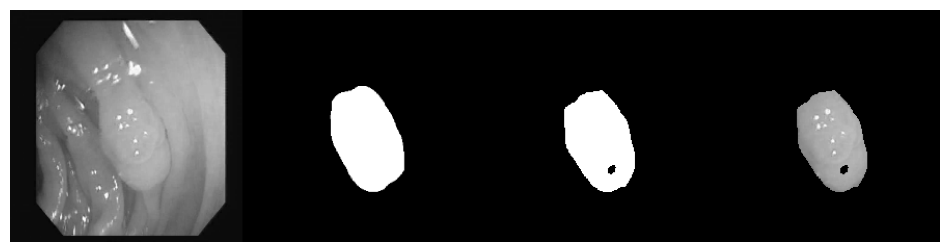

 Epoch: 14 of 100, Iter.: 46 of 46, Train Loss: 0.035204, IoU: 0.944015, Dice: 0.970294
 Epoch: 14 of 100, Iter.: 46 of 46, Valid Loss: 0.208203, IoU: 0.806189, Dice: 0.877406


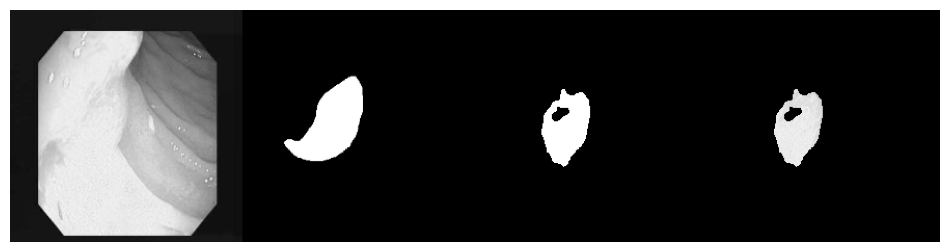

 Epoch: 15 of 100, Iter.: 46 of 46, Train Loss: 0.031296, IoU: 0.949854, Dice: 0.973723
 Epoch: 15 of 100, Iter.: 46 of 46, Valid Loss: 0.215119, IoU: 0.797866, Dice: 0.866139


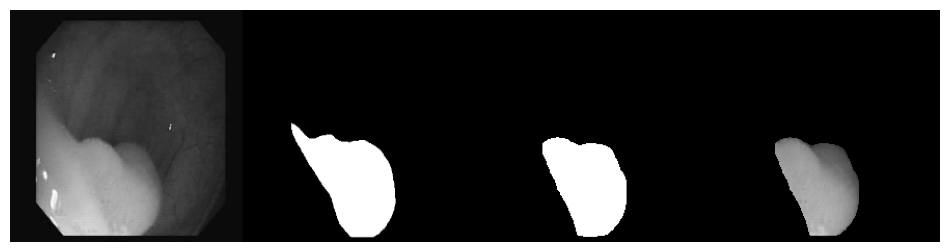

 Epoch: 16 of 100, Iter.: 46 of 46, Train Loss: 0.029330, IoU: 0.952157, Dice: 0.974929
 Epoch: 16 of 100, Iter.: 46 of 46, Valid Loss: 0.215251, IoU: 0.806609, Dice: 0.877386


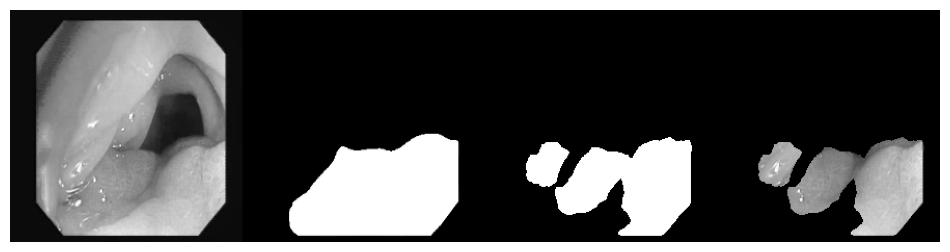

 Epoch: 17 of 100, Iter.: 46 of 46, Train Loss: 0.029295, IoU: 0.953551, Dice: 0.975855
 Epoch: 17 of 100, Iter.: 46 of 46, Valid Loss: 0.207291, IoU: 0.808069, Dice: 0.877944


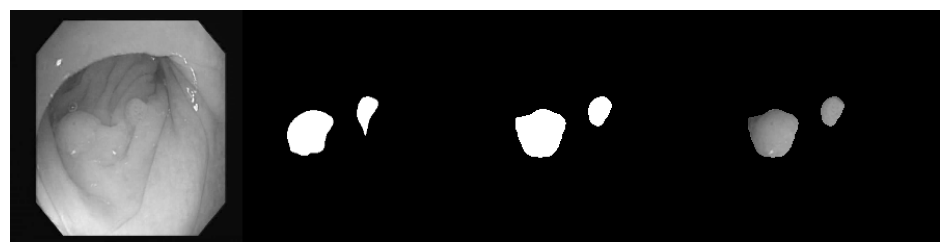

 Epoch: 18 of 100, Iter.: 46 of 46, Train Loss: 0.029115, IoU: 0.954043, Dice: 0.976185
 Epoch: 18 of 100, Iter.: 46 of 46, Valid Loss: 0.233859, IoU: 0.802949, Dice: 0.874083


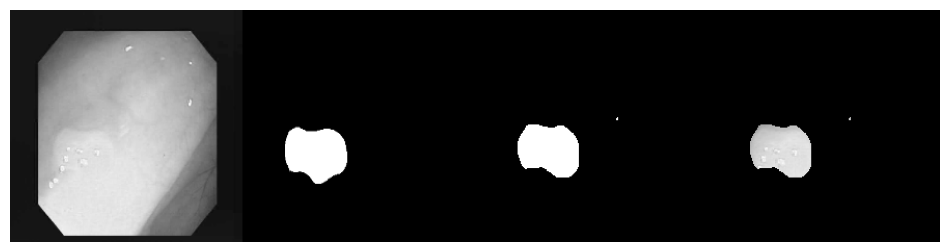

 Epoch: 19 of 100, Iter.: 46 of 46, Train Loss: 0.026064, IoU: 0.959527, Dice: 0.979173
 Epoch: 19 of 100, Iter.: 46 of 46, Valid Loss: 0.216846, IoU: 0.808264, Dice: 0.878190


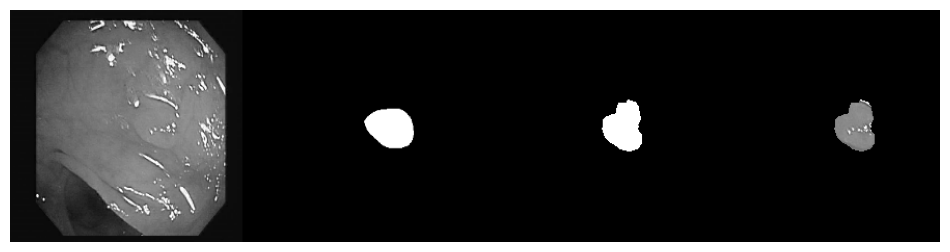

 Epoch: 20 of 100, Iter.: 46 of 46, Train Loss: 0.025133, IoU: 0.960706, Dice: 0.979748
 Epoch: 20 of 100, Iter.: 46 of 46, Valid Loss: 0.234515, IoU: 0.806299, Dice: 0.876743


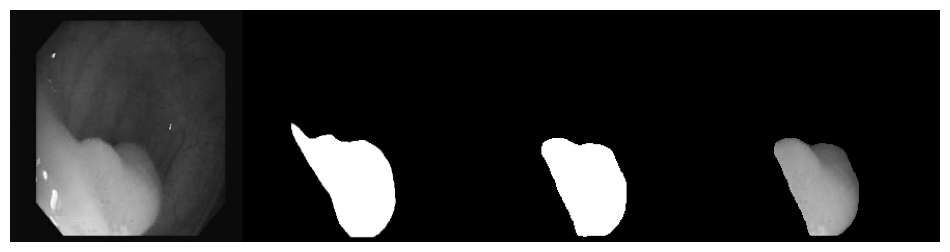

 Epoch: 21 of 100, Iter.: 46 of 46, Train Loss: 0.024851, IoU: 0.960029, Dice: 0.979319
 Epoch: 21 of 100, Iter.: 46 of 46, Valid Loss: 0.237855, IoU: 0.803240, Dice: 0.873902


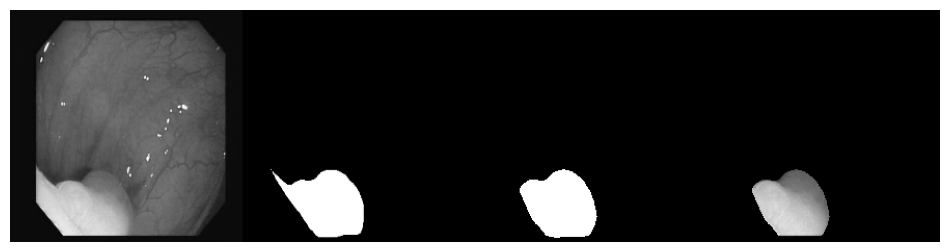

 Epoch: 22 of 100, Iter.: 46 of 46, Train Loss: 0.023978, IoU: 0.961522, Dice: 0.980157
 Epoch: 22 of 100, Iter.: 46 of 46, Valid Loss: 0.237127, IoU: 0.809397, Dice: 0.878905


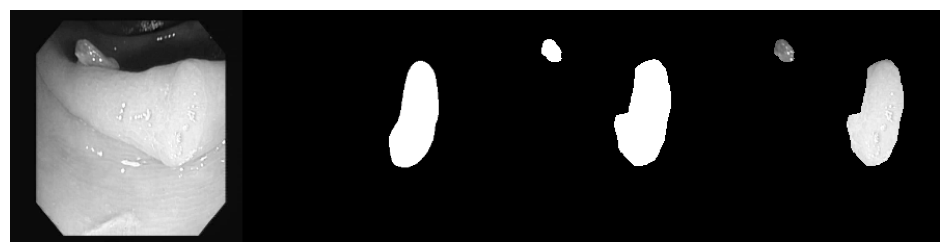

 Epoch: 23 of 100, Iter.: 46 of 46, Train Loss: 0.022406, IoU: 0.965598, Dice: 0.982380
 Epoch: 23 of 100, Iter.: 46 of 46, Valid Loss: 0.229223, IoU: 0.806250, Dice: 0.877368


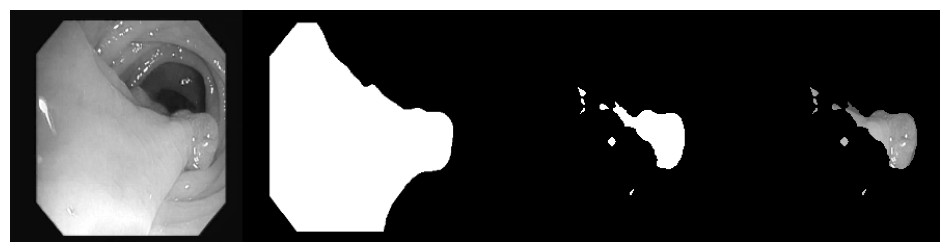

 Epoch: 24 of 100, Iter.: 46 of 46, Train Loss: 0.022719, IoU: 0.964609, Dice: 0.981821
 Epoch: 24 of 100, Iter.: 46 of 46, Valid Loss: 0.234043, IoU: 0.806790, Dice: 0.876138


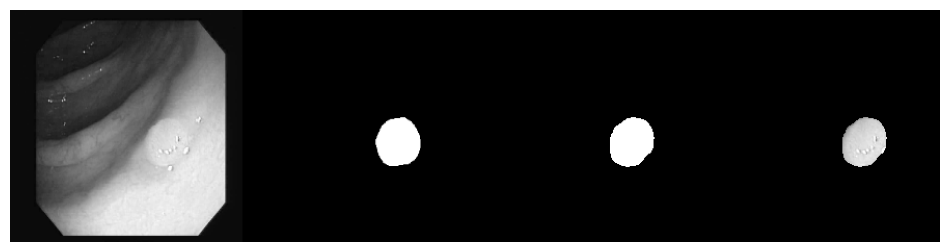

 Epoch: 25 of 100, Iter.: 46 of 46, Train Loss: 0.021115, IoU: 0.966731, Dice: 0.982975
 Epoch: 25 of 100, Iter.: 46 of 46, Valid Loss: 0.243983, IoU: 0.805751, Dice: 0.875763


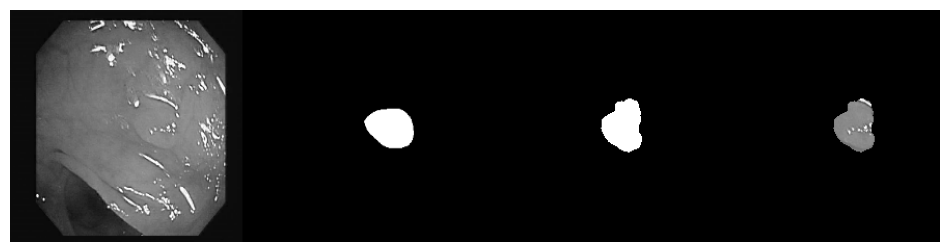

 Epoch: 26 of 100, Iter.: 46 of 46, Train Loss: 0.019144, IoU: 0.969879, Dice: 0.984600
 Epoch: 26 of 100, Iter.: 46 of 46, Valid Loss: 0.248392, IoU: 0.808290, Dice: 0.876645


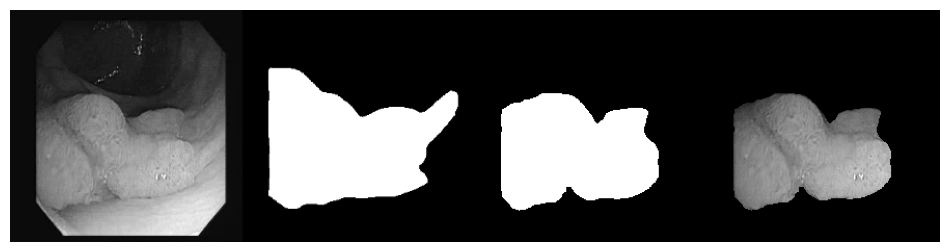

 Epoch: 27 of 100, Iter.: 46 of 46, Train Loss: 0.018812, IoU: 0.970092, Dice: 0.984718
 Epoch: 27 of 100, Iter.: 46 of 46, Valid Loss: 0.267256, IoU: 0.805516, Dice: 0.875242


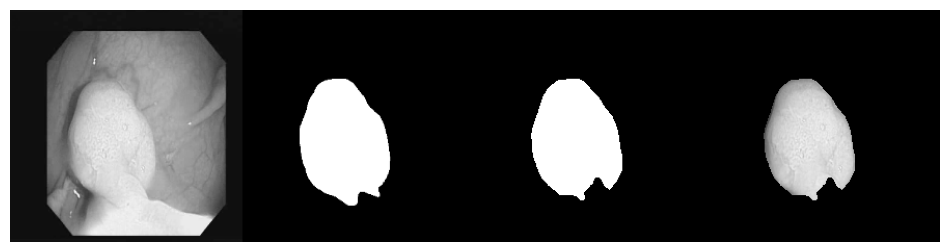

 Epoch: 28 of 100, Iter.: 46 of 46, Train Loss: 0.018173, IoU: 0.970156, Dice: 0.984692
 Epoch: 28 of 100, Iter.: 46 of 46, Valid Loss: 0.252508, IoU: 0.809217, Dice: 0.877926


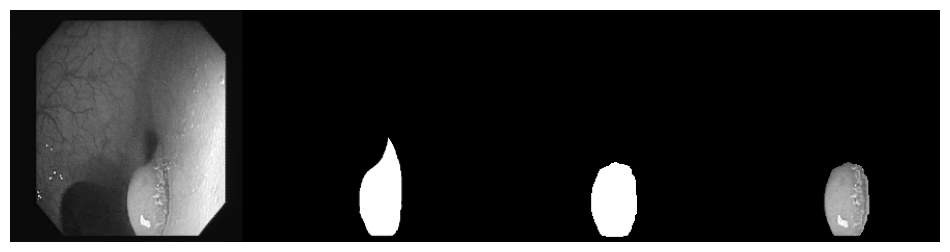

 Epoch: 29 of 100, Iter.: 46 of 46, Train Loss: 0.016873, IoU: 0.973312, Dice: 0.986408
 Epoch: 29 of 100, Iter.: 46 of 46, Valid Loss: 0.260715, IoU: 0.806973, Dice: 0.876186


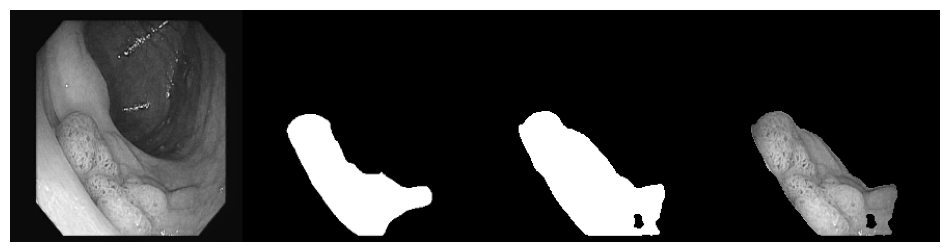

 Epoch: 30 of 100, Iter.: 46 of 46, Train Loss: 0.016728, IoU: 0.973458, Dice: 0.986475
 Epoch: 30 of 100, Iter.: 46 of 46, Valid Loss: 0.259290, IoU: 0.812909, Dice: 0.881582


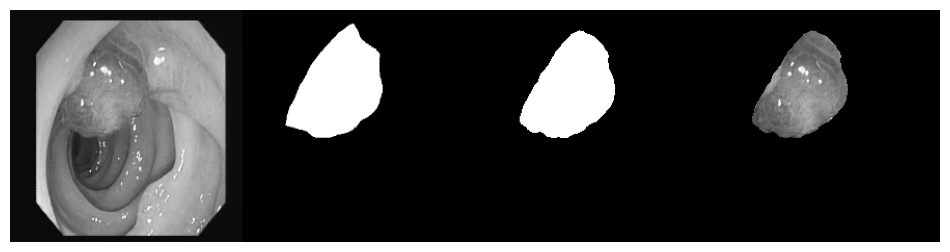

 Epoch: 31 of 100, Iter.: 46 of 46, Train Loss: 0.015913, IoU: 0.975252, Dice: 0.987376
 Epoch: 31 of 100, Iter.: 46 of 46, Valid Loss: 0.276802, IoU: 0.802564, Dice: 0.872474


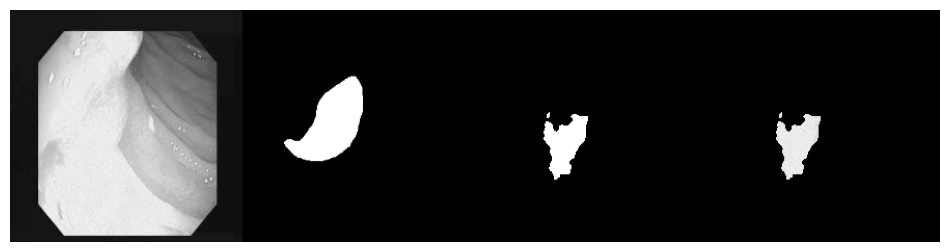

 Epoch: 32 of 100, Iter.: 46 of 46, Train Loss: 0.015378, IoU: 0.975879, Dice: 0.987738
 Epoch: 32 of 100, Iter.: 46 of 46, Valid Loss: 0.281766, IoU: 0.807646, Dice: 0.876892


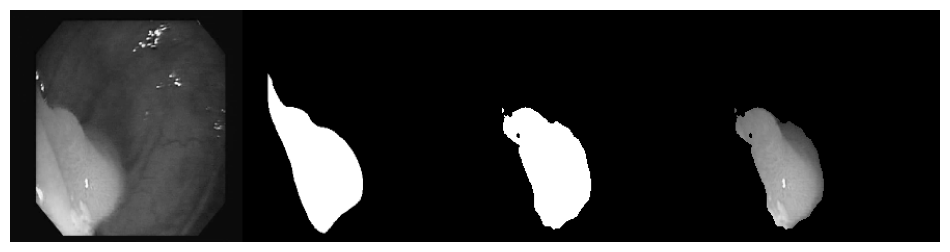

 Epoch: 33 of 100, Iter.: 46 of 46, Train Loss: 0.016129, IoU: 0.975641, Dice: 0.987615
 Epoch: 33 of 100, Iter.: 46 of 46, Valid Loss: 0.278809, IoU: 0.807684, Dice: 0.876495


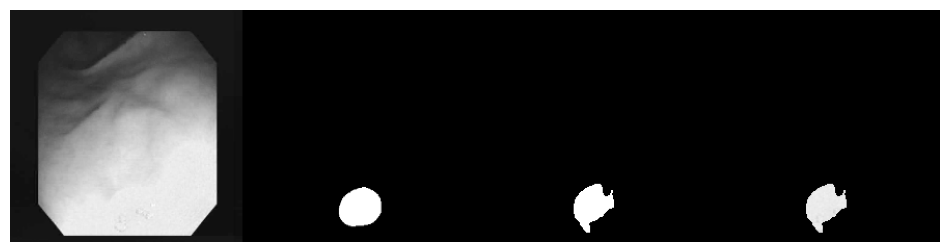

 Epoch: 34 of 100, Iter.: 46 of 46, Train Loss: 0.015753, IoU: 0.974858, Dice: 0.987190
 Epoch: 34 of 100, Iter.: 46 of 46, Valid Loss: 0.278563, IoU: 0.806058, Dice: 0.875790


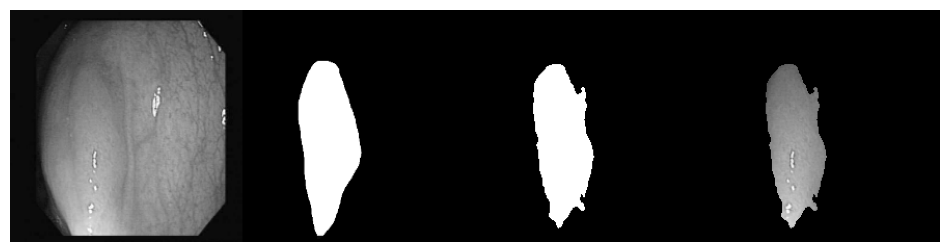

 Epoch: 35 of 100, Iter.: 46 of 46, Train Loss: 0.016504, IoU: 0.974000, Dice: 0.986753
 Epoch: 35 of 100, Iter.: 46 of 46, Valid Loss: 0.261660, IoU: 0.806485, Dice: 0.875984


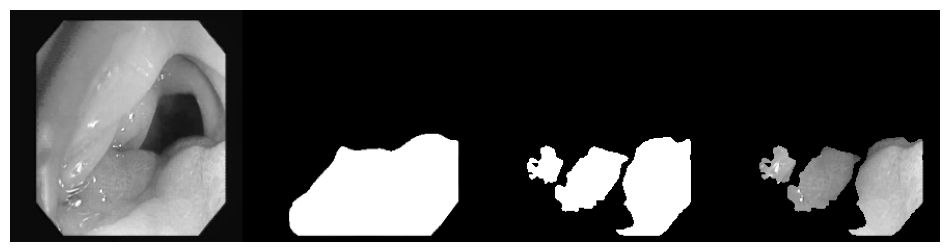

 Epoch: 36 of 100, Iter.: 46 of 46, Train Loss: 0.015053, IoU: 0.975784, Dice: 0.987675
 Epoch: 36 of 100, Iter.: 46 of 46, Valid Loss: 0.284687, IoU: 0.806881, Dice: 0.876072


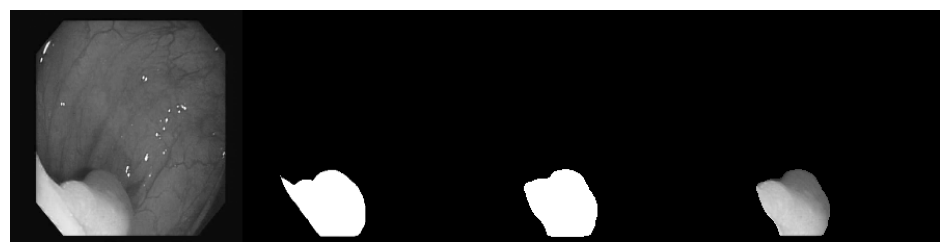

 Epoch: 37 of 100, Iter.: 46 of 46, Train Loss: 0.013451, IoU: 0.978673, Dice: 0.989168
 Epoch: 37 of 100, Iter.: 46 of 46, Valid Loss: 0.289526, IoU: 0.807254, Dice: 0.875936


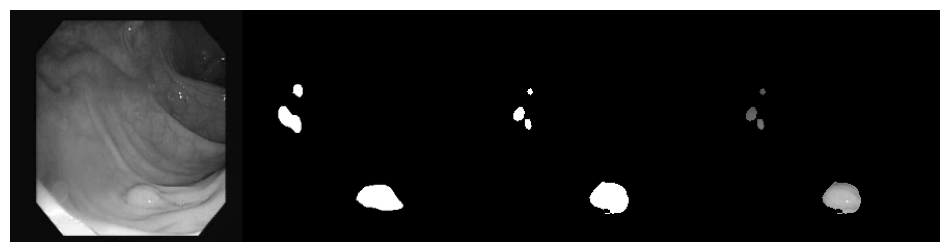

 Epoch: 38 of 100, Iter.: 46 of 46, Train Loss: 0.012499, IoU: 0.979916, Dice: 0.989808
 Epoch: 38 of 100, Iter.: 46 of 46, Valid Loss: 0.306150, IoU: 0.807873, Dice: 0.876227


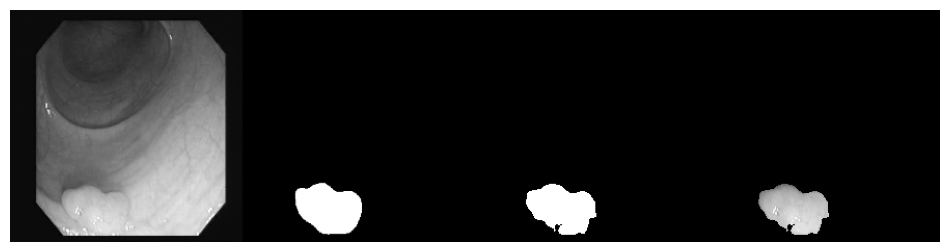

 Epoch: 39 of 100, Iter.: 46 of 46, Train Loss: 0.012459, IoU: 0.980263, Dice: 0.989986
 Epoch: 39 of 100, Iter.: 46 of 46, Valid Loss: 0.303431, IoU: 0.803849, Dice: 0.874024


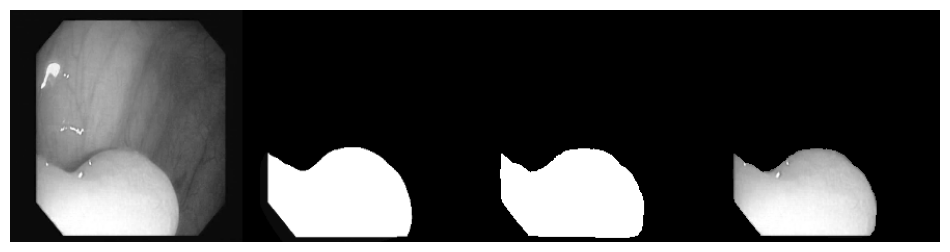

 Epoch: 40 of 100, Iter.: 46 of 46, Train Loss: 0.012833, IoU: 0.979164, Dice: 0.989423
 Epoch: 40 of 100, Iter.: 46 of 46, Valid Loss: 0.304422, IoU: 0.806656, Dice: 0.875878


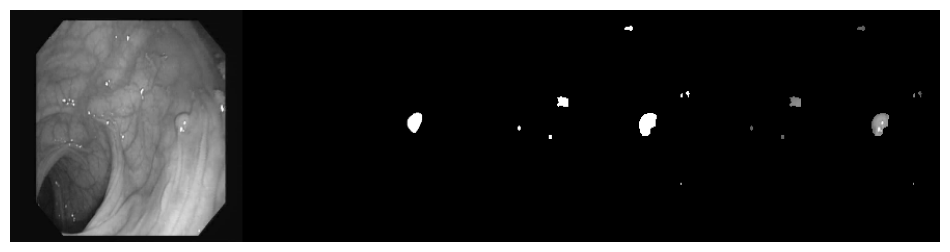

 Epoch: 41 of 100, Iter.: 46 of 46, Train Loss: 0.012627, IoU: 0.980267, Dice: 0.989994
 Epoch: 41 of 100, Iter.: 46 of 46, Valid Loss: 0.304018, IoU: 0.807928, Dice: 0.877855


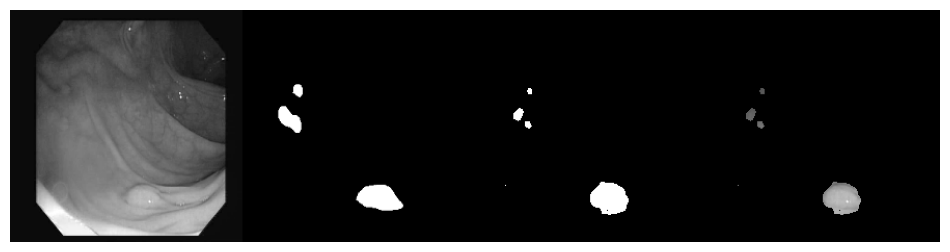

 Epoch: 42 of 100, Iter.: 46 of 46, Train Loss: 0.011675, IoU: 0.982083, Dice: 0.990931
 Epoch: 42 of 100, Iter.: 46 of 46, Valid Loss: 0.316441, IoU: 0.808580, Dice: 0.878264


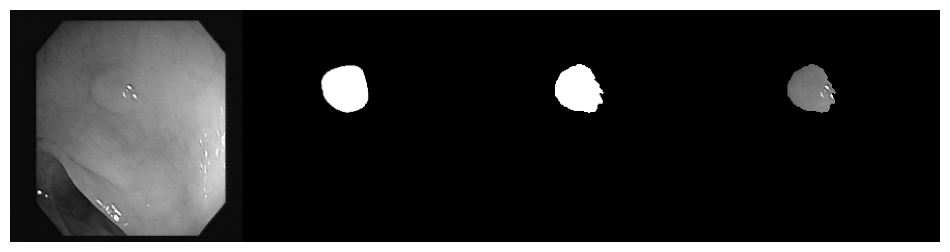

 Epoch: 43 of 100, Iter.: 46 of 46, Train Loss: 0.011328, IoU: 0.982089, Dice: 0.990923
 Epoch: 43 of 100, Iter.: 46 of 46, Valid Loss: 0.319475, IoU: 0.808346, Dice: 0.877927


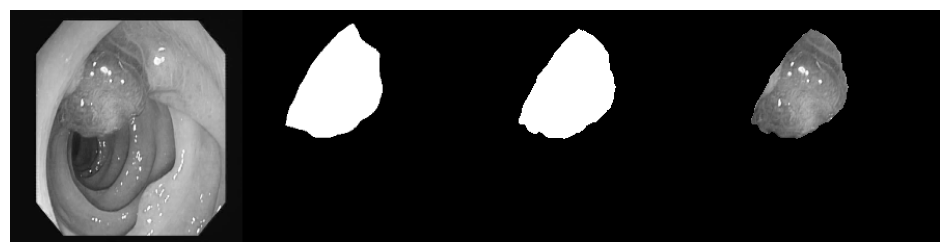

 Epoch: 44 of 100, Iter.: 46 of 46, Train Loss: 0.010857, IoU: 0.983194, Dice: 0.991496
 Epoch: 44 of 100, Iter.: 46 of 46, Valid Loss: 0.327071, IoU: 0.811004, Dice: 0.879286


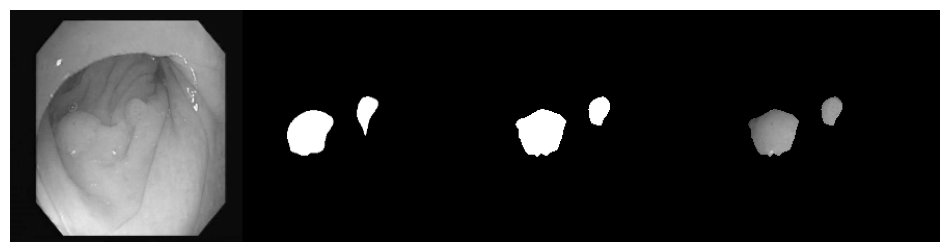

 Epoch: 45 of 100, Iter.: 46 of 46, Train Loss: 0.010143, IoU: 0.984392, Dice: 0.992110
 Epoch: 45 of 100, Iter.: 46 of 46, Valid Loss: 0.308093, IoU: 0.806893, Dice: 0.876819


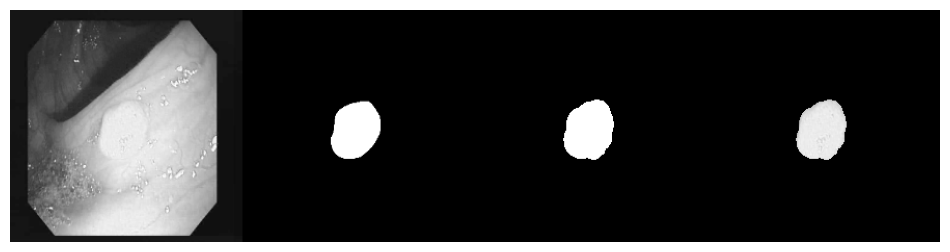

 Epoch: 46 of 100, Iter.: 46 of 46, Train Loss: 0.010320, IoU: 0.983684, Dice: 0.991736
 Epoch: 46 of 100, Iter.: 46 of 46, Valid Loss: 0.336785, IoU: 0.803335, Dice: 0.872868


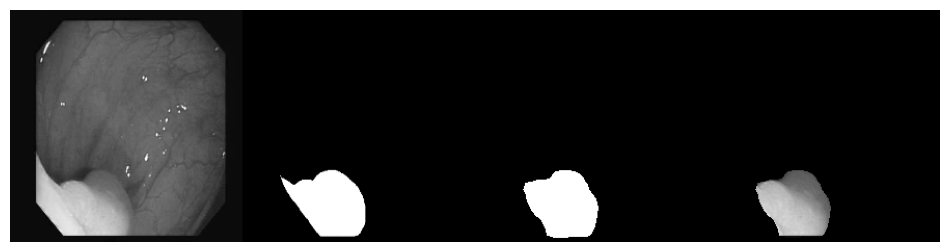

 Epoch: 47 of 100, Iter.: 46 of 46, Train Loss: 0.010101, IoU: 0.983834, Dice: 0.991801
 Epoch: 47 of 100, Iter.: 46 of 46, Valid Loss: 0.336118, IoU: 0.810289, Dice: 0.879390


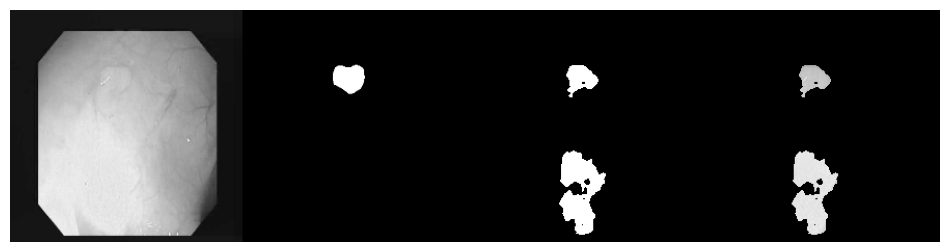

 Epoch: 48 of 100, Iter.: 46 of 46, Train Loss: 0.010130, IoU: 0.983702, Dice: 0.991742
 Epoch: 48 of 100, Iter.: 46 of 46, Valid Loss: 0.315033, IoU: 0.808769, Dice: 0.878097


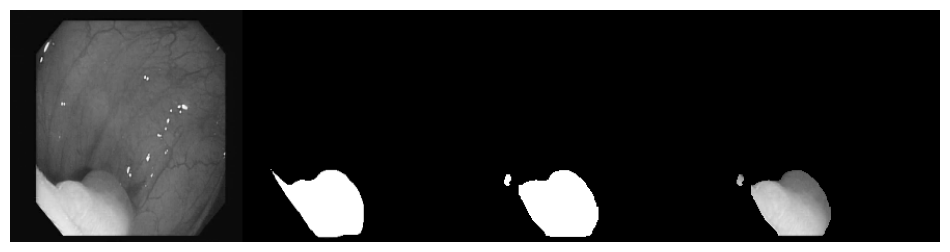

 Epoch: 49 of 100, Iter.: 46 of 46, Train Loss: 0.010043, IoU: 0.984208, Dice: 0.992007
 Epoch: 49 of 100, Iter.: 46 of 46, Valid Loss: 0.319834, IoU: 0.805055, Dice: 0.875608


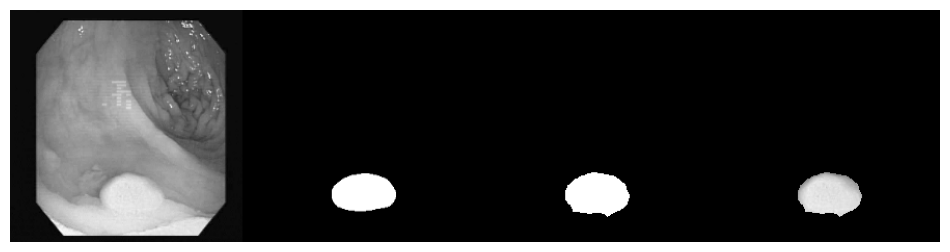

 Epoch: 50 of 100, Iter.: 46 of 46, Train Loss: 0.008549, IoU: 0.986659, Dice: 0.993259
 Epoch: 50 of 100, Iter.: 46 of 46, Valid Loss: 0.335812, IoU: 0.807029, Dice: 0.876668


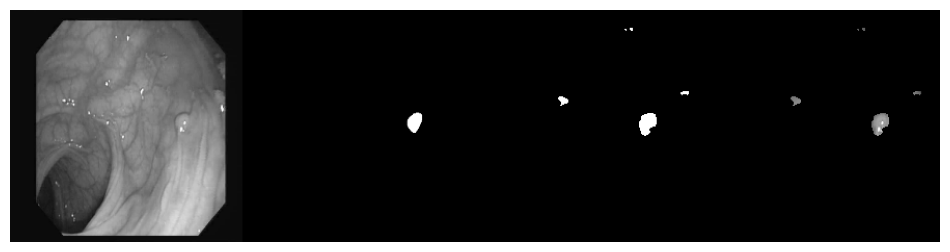

 Epoch: 51 of 100, Iter.: 46 of 46, Train Loss: 0.007560, IoU: 0.988354, Dice: 0.994127
 Epoch: 51 of 100, Iter.: 46 of 46, Valid Loss: 0.351430, IoU: 0.808981, Dice: 0.878387


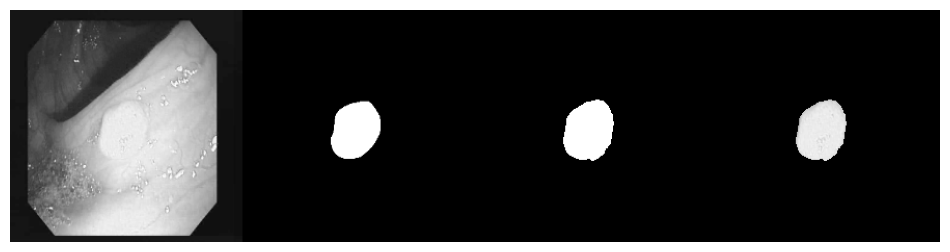


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 1h 41s, sys: 28min 25s, total: 1h 29min 7s
Wall time: 1h 25min 48s


In [25]:
%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/ehdgus575/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:30, Best_IOU:0.8129, Best_DiceScore:0.8816


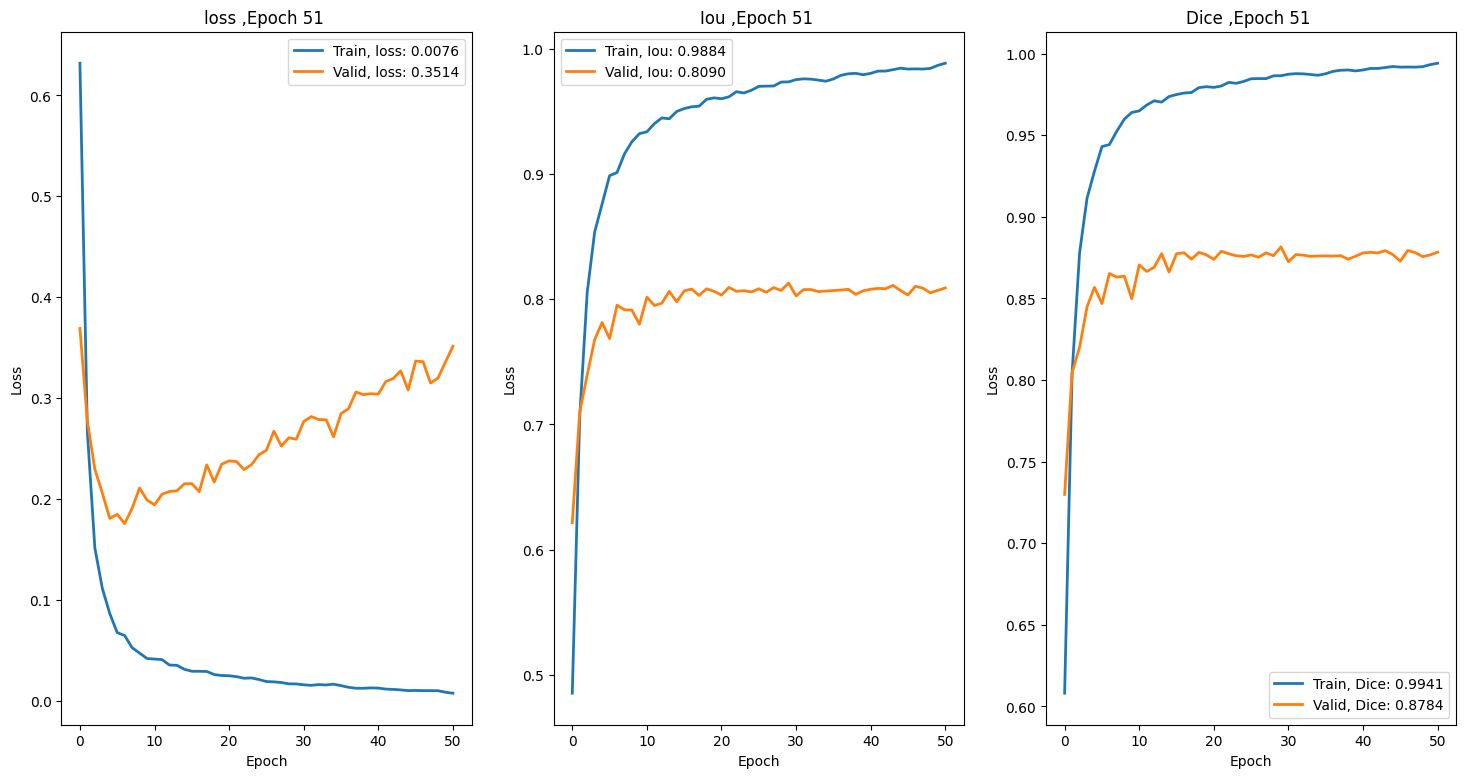

In [26]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')
#print(f'End_time: {end_time}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()